# Experimenting with homography and distance estimation

**Date created:** 2022/02/02<br>
**Last modified:** 2022/02/13<br>
**Description:** Production of functions for exploring and experimenting with homography and distance estimation.<br>
**Originator / Point of Contact:** [Valentin Sonntag](https://github.com/ValentinSonntag)<br>

### 1. Import dependencies, set directory paths and load data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import seaborn as sns
import skimage.io
import cv2
from math import ceil
from time import perf_counter
from sklearn.cluster import DBSCAN

In [2]:
sns.set_style('white')

In [3]:
# Get project path and other key directories for project
PROJECT_PATH = "F:\\GDP_group5-master" # os.sep.join(os.getcwd().split(os.sep)[:-1])
DATA_DIR = os.path.join(PROJECT_PATH, 'data')

# Set paths to input images and alphapose-generate pose visualisations
IMAGE_DIR = os.path.join(DATA_DIR, 'temp_dataset')
ALPHAPOSE_RESULTS_DIR = os.path.join(DATA_DIR, 'temp_data_alphapose_results')

In [4]:
# Read json results generated from the AlphaPose model
alphap_results = pd.read_json(os.path.join(DATA_DIR, 'alphapose-results.json'))

In [5]:
# preview images within our image directory
os.listdir(IMAGE_DIR) # !ls {IMAGE_DIR}

['example-input.png',
 'train_0.png',
 'train_1.png',
 'train_10.png',
 'train_100.png',
 'train_1000.png',
 'train_1001.png',
 'train_1002.png',
 'train_1003.png',
 'train_1004.png',
 'train_1005.png',
 'train_1006.png',
 'train_1007.png',
 'train_1008.png',
 'train_1009.png',
 'train_101.png',
 'train_1010 (1).png',
 'train_1010.png',
 'train_1011.png',
 'train_1012.png',
 'train_1013.png',
 'train_1014.png',
 'train_1015.png',
 'train_1016.png',
 'train_1017.png',
 'train_1018.png',
 'train_1019.png',
 'train_102.png',
 'train_1020.png',
 'train_1021.png',
 'train_1022.png',
 'train_1023.png',
 'train_1035.png',
 'train_1037.png',
 'train_1040.png',
 'train_1048.png',
 'train_1065.png',
 'train_1084.png',
 'train_1109.png',
 'train_1120.png',
 'train_1121.png',
 'train_1130.png']

In [7]:
# Get names of all unique image files in the image directory
image_files = [x for x in os.listdir(IMAGE_DIR) if x.endswith('.png')]

print(f"Number of image files found: {len(image_files)}")

Number of image files found: 42


### 2. Homography


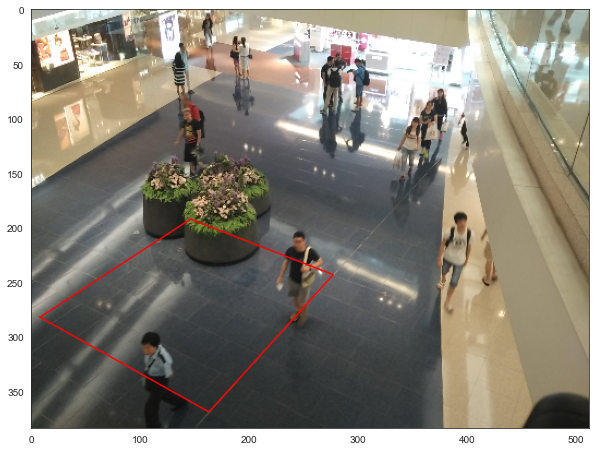

In [319]:
img_index = 35

# Four corners of the reference in source image clockwise from bottom left 
pts_src = np.array([[8, 282], [146, 192], [277, 243], [163, 369]])

# Show the image with the reference
img_array = skimage.io.imread(os.path.join(IMAGE_DIR, image_files[img_index]))
plt.figure(figsize=(10,8))
plt.imshow(img_array)
plt.plot(list(pts_src[:, 0]) + [pts_src[0, 0]], list(pts_src[:, 1]) + [pts_src[0, 1]], '-r')
# plt.grid(True)
plt.show()

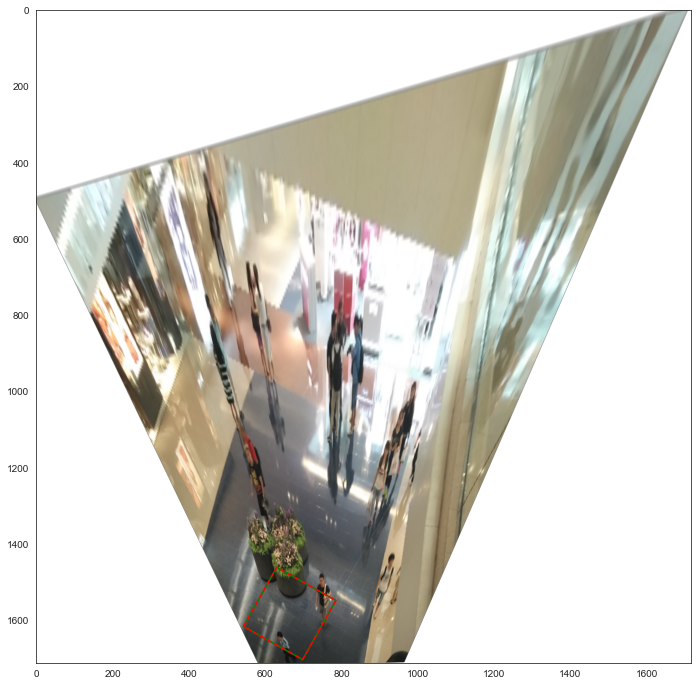

In [317]:
# Four corners of the reference in destination image (keep bottom side same size and position)
vect = pts_src[3, :] - pts_src[0, :]
pts_dst = np.array([pts_src[0, :].copy(), [pts_src[0, 0]+vect[1], pts_src[0, 1]-vect[0]], [pts_src[3, 0]+vect[1], pts_src[3, 1]-vect[0]], pts_src[3, :].copy()])
"""
# Check size
for i in range(4):
  print("Side " + str(i+1) + " size: " + str(((pts_dst[i-1, 0] - pts_dst[i, 0])**2 + (pts_dst[i-1, 1] - pts_dst[i, 1])**2)**0.5))
"""

# Calculate Homography matrix h (where normalize_with_last_variable_equal_one(h @ source) = destination)
h, status = cv2.findHomography(pts_src, pts_dst)
"""
# Check homography transformation
print("Source:\n", np.array([[pts_src[1, 0]], [pts_src[1, 1]], [1]])) # Source
print("\nDestination:\n", np.array([[pts_dst[1, 0]], [pts_dst[1, 1]], [1]])) # Destination
r = h @ np.array([[pts_src[1, 0]], [pts_src[1, 1]], [1]])
print("\nResult:\n", r / r[-1])
"""

corners = [(x, y) for x in [0, img_array.shape[1]] for y in [0, img_array.shape[0]]]
# Limits of the top view image
x_lim = [np.inf, -np.inf]
y_lim = [np.inf, -np.inf]
for c in corners:
    r = h @ np.array([[c[0]], [c[1]], [1]])
    r = r / r[-1]
    x_lim[0] = min(x_lim[0], r[0, 0])
    x_lim[1] = max(x_lim[1], r[0, 0])
    y_lim[0] = min(y_lim[0], r[1, 0])
    y_lim[1] = max(y_lim[1], r[1, 0])

# Change the reference destination position
pts_dst = pts_dst - np.array([x_lim[0], y_lim[0]])
h, status = cv2.findHomography(pts_src, pts_dst)

# Warp source image to destination based on homography (with size=(y_size, x_size) format)
im_out = cv2.warpPerspective(img_array, h, (ceil(y_lim[1]-y_lim[0]), ceil(x_lim[1]-x_lim[0])))

# Reference in new projection 
pts_src_trans = []
for p in pts_src:
    res = h @ np.array([[p[0]], [p[1]], [1]])
    res = res / res[-1]
    pts_src_trans.append((res[0, 0], res[1, 0]))
pts_src_trans = np.array(pts_src_trans)

plt.figure(figsize=(15,12))
# Display image
plt.imshow(im_out)
plt.plot(list(pts_src_trans[:, 0]) + [pts_src_trans[0, 0]], list(pts_src_trans[:, 1]) + [pts_src_trans[0, 1]], '-g') # Result for reference
plt.plot(list(pts_dst[:, 0]) + [pts_dst[0, 0]], list(pts_dst[:, 1]) + [pts_dst[0, 1]], '--r') # Target for reference
plt.show()

### 3. Distance Estimation

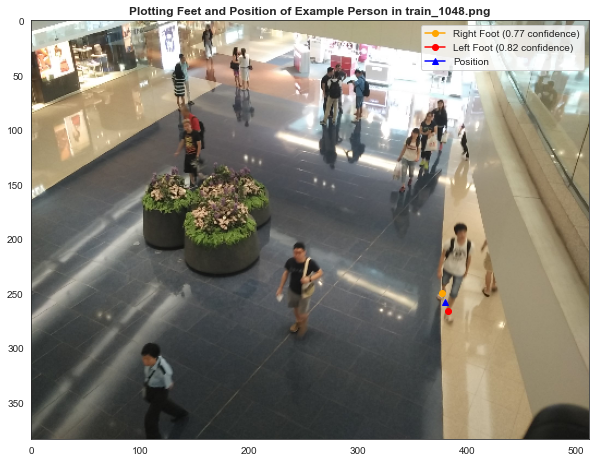

In [181]:
example_img = image_files[img_index]

# Gather only the first persons pose features for this example
example_pose = np.array(alphap_results.loc[alphap_results['image_id'] == example_img]['keypoints'].iloc[0])

# Show the image with the reference and the feet positions
img_array = skimage.io.imread(os.path.join(IMAGE_DIR, image_files[img_index]))
plt.figure(figsize=(10,8))
plt.imshow(img_array)
plt.plot(example_pose[-3], example_pose[-2], marker='o', color='orange', label='Right Foot (' + str(example_pose[-1].round(2)) + ' confidence)')
plt.plot(example_pose[-6], example_pose[-5], marker='o', color='red', label='Left Foot (' + str(example_pose[-4].round(2)) + ' confidence)')
plt.plot((example_pose[-3]+example_pose[-6])/2, (example_pose[-2]+example_pose[-5])/2, marker='^', color='blue', label='Position')
plt.title(f"Plotting Feet and Position of Example Person in {example_img}", weight="bold", fontsize=14)
plt.legend()
plt.show()

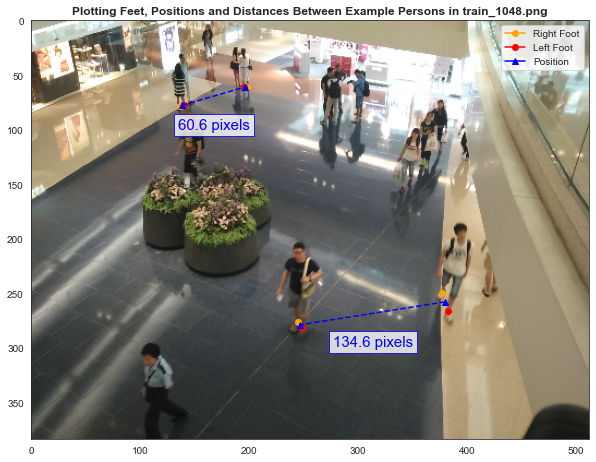

In [205]:
# Gather only two pairs of persons pose features for this example
example_poses_pair_1 = np.array(alphap_results.loc[alphap_results['image_id'] == example_img]['keypoints'].iloc[[0, 1]])
example_poses_pair_2 = np.array(alphap_results.loc[alphap_results['image_id'] == example_img]['keypoints'].iloc[[5, 6]])

# Show the imag with the reference and the feet positions
img_array = skimage.io.imread(os.path.join(IMAGE_DIR, image_files[img_index]))
plt.figure(figsize=(10,8))
plt.imshow(img_array)
record_positions = []
# Calculate distance between two pairs of persons
for example_pose in [example_poses_pair_1, example_poses_pair_2]:
    pos = []
    # Display right and left feet positions and their average positions, considered as ground positions of the persons
    for person in example_pose:
        plt.plot(person[-3], person[-2], marker='o', color='orange', label='Right Foot')
        plt.plot(person[-6], person[-5], marker='o', color='red', label='Left Foot')
        record_positions.append(((person[-3]+person[-6])/2, (person[-2]+person[-5])/2))
        plt.plot(record_positions[-1][0], record_positions[-1][1], marker='^', color='blue', label='Position')
        pos.append(((person[-3]+person[-6])/2, (person[-2]+person[-5])/2))
    plt.plot([p[0] for p in pos], [p[1] for p in pos], '--b')
    # Calculate distance in pixels
    x = (pos[0][0]+pos[1][0])/2
    y = (pos[0][1]+pos[1][1])/2 + 30
    d = ((pos[0][0]-pos[1][0])**2 + (pos[0][1]-pos[1][1])**2)**0.5
    t = plt.text(x, y, str(round(d, 1)) + ' pixels', color='blue', fontsize=15, horizontalalignment='center')
    t.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='blue'))

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.title(f"Plotting Feet, Positions and Distances Between Example Persons in {example_img}", weight="bold", fontsize=14)
plt.show()

#### 3.1. Homography

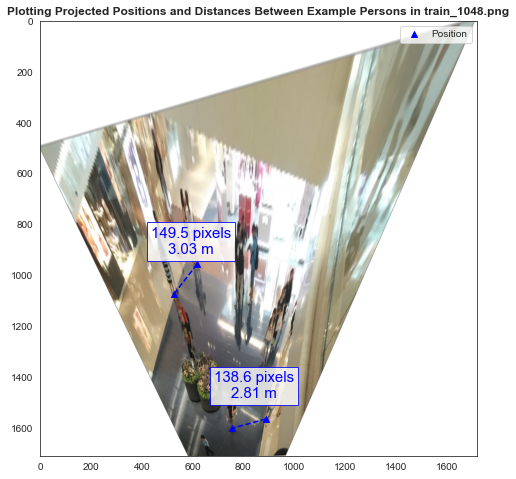

In [183]:
# Positions in new projection 
pos_trans = []
for p in record_positions:
    res = h @ np.array([[p[0]], [p[1]], [1]])
    res = res / res[-1]
    pos_trans.append((res[0, 0], res[1, 0]))
pos_trans = np.array(pos_trans)

# Distance scale
scale = 3.6 / ((pts_dst[0, 0] - pts_dst[1, 0])**2 + (pts_dst[0, 1] - pts_dst[1, 1])**2)**0.5

plt.figure(figsize=(10,8))
# Display image
plt.imshow(im_out)
plt.scatter(pos_trans[:, 0], pos_trans[:, 1], marker='^', color='blue', label='Position')
for pair in range(0, 4, 2):
    plt.plot([pos_trans[pair, 0], pos_trans[pair+1, 0]], [pos_trans[pair, 1], pos_trans[pair+1, 1]], '--b')
    # Calculate distance in pixels and in meters
    x = (pos_trans[pair, 0]+pos_trans[pair+1, 0])/2 + 20
    y = (pos_trans[pair, 1]+pos_trans[pair+1, 1])/2 - 100
    d = ((pos_trans[pair, 0]-pos_trans[pair+1, 0])**2 + (pos_trans[pair, 1]-pos_trans[pair+1, 1])**2)**0.5
    t = plt.text(x, y, str(round(d, 1)) + ' pixels\n' + str(round(d * scale, 2)) + ' m', color='blue', fontsize=15, horizontalalignment='center')
    t.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='blue'))
plt.legend()
plt.title(f"Plotting Projected Positions and Distances Between Example Persons in {example_img}", weight="bold", fontsize=14)
plt.show()

#### 3.2. Pose features scale


Pair 0:
Method 1: 3.18 m
Method 2: 3.11 m
Method 3: 3.13 m
Method 4: 3.13 m

Pair 1:
Method 1: 2.47 m
Method 2: 3.25 m
Method 3: 3.21 m
Method 4: 3.25 m


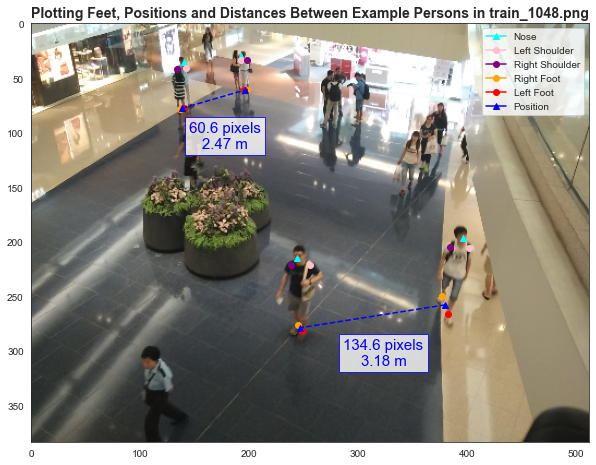

In [270]:
H = 1.5 # Nose to feet average distance
W = 0.4 # Shoulder to shoulder average distance

example_img = image_files[img_index]

# Gather only two pairs of persons pose features for this example
example_poses_pair_1 = np.array(alphap_results.loc[alphap_results['image_id'] == example_img]['keypoints'].iloc[[0, 1]])
example_poses_pair_2 = np.array(alphap_results.loc[alphap_results['image_id'] == example_img]['keypoints'].iloc[[5, 6]])

# Show the imag with the reference and the feet positions
img_array = skimage.io.imread(os.path.join(IMAGE_DIR, image_files[img_index]))
plt.figure(figsize=(10,8))
plt.imshow(img_array)
record_positions = []
# Calculate distance between two pairs of persons
for i, example_pose in enumerate([example_poses_pair_1, example_poses_pair_2]):
    pos = []
    size = []
    # Display right and left feet positions and their average positions, considered as ground positions of the persons
    for person in example_pose:
        plt.plot(person[0], person[1], marker='^', color='cyan', label='Nose')
        plt.plot(person[15], person[16], marker='o', color='pink', label='Left Shoulder')
        plt.plot(person[18], person[19], marker='o', color='purple', label='Right Shoulder')
        plt.plot(person[-3], person[-2], marker='o', color='orange', label='Right Foot')
        plt.plot(person[-6], person[-5], marker='o', color='red', label='Left Foot')
        record_positions.append(((person[-3]+person[-6])/2, (person[-2]+person[-5])/2))
        plt.plot(record_positions[-1][0], record_positions[-1][1], marker='^', color='blue', label='Position')
        pos.append((record_positions[-1][0], record_positions[-1][1]))
        # Record 
        size.append(((person[15]-person[18], person[16]-person[19]), (person[0]-record_positions[-1][0], person[1]-record_positions[-1][1]))) # nose to feet + shoulder to shoulder
    plt.plot([p[0] for p in pos], [p[1] for p in pos], '--b')

    # Calculate distance in pixels
    x = (pos[0][0]+pos[1][0])/2 + 10
    y = (pos[0][1]+pos[1][1])/2 + 45
    d = ((pos[0][0]-pos[1][0])**2 + (pos[0][1]-pos[1][1])**2)**0.5

    # Calculate distance in meters
    print(f"\nPair {str(i)}:")
    pers_1_w = (size[0][0][0]**2+size[0][0][1]**2)**0.5
    pers_1_h = (size[0][1][0]**2+size[0][1][1]**2)**0.5
    pers_2_w = (size[1][0][0]**2+size[1][0][1]**2)**0.5
    pers_2_h = (size[1][1][0]**2+size[1][1][1]**2)**0.5
    scale_x = W / ((pers_1_w + pers_2_w)/2) # Average x scale of 2 persons to consider deformations
    scale_y = H / ((pers_1_h + pers_2_h)/2) # Average y scale of 2 persons to consider deformations

    # First method = use height as scale
    print("Method 1: " + str(round(d*scale_y, 2)) + " m")
    t = plt.text(x, y, str(round(d, 1)) + ' pixels\n' + str(round(d*scale_y, 2)) + ' m', color='blue', fontsize=15, horizontalalignment='center')
    t.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='blue'))

    # Second method = use height as y scale and shoulders as x scale (height for y axis and width for x axis = no projection on distance vector)
    d_2 = ((abs(pos[0][0]-pos[1][0])*scale_x)**2 + (abs(pos[0][1]-pos[1][1])*scale_y)**2)**0.5
    print("Method 2: " + str(round(d_2, 2)) + " m")

    # Third method = vector projection for scale (but always average between 2 persons (considering deformations))
    vect_dist = (pos[0][0]-pos[1][0], pos[0][1]-pos[1][1])
    # Calculate projections of height and width vectors for each person on distance vector
    pers_1_w_proj = vect_dist[0]*size[0][0][0] + vect_dist[1]*size[0][0][1]
    pers_1_h_proj = vect_dist[0]*size[0][1][0] + vect_dist[1]*size[0][1][1]
    pers_2_w_proj = vect_dist[0]*size[1][0][0] + vect_dist[1]*size[1][0][1]
    pers_2_h_proj = vect_dist[0]*size[1][1][0] + vect_dist[1]*size[1][1][1]
    pers_1_w_r = abs(pers_1_w_proj) / np.linalg.norm(vect_dist) / np.linalg.norm(size[0][0])
    pers_1_h_r = abs(pers_1_h_proj) / np.linalg.norm(vect_dist) / np.linalg.norm(size[0][1])
    pers_2_w_r = abs(pers_2_w_proj) / np.linalg.norm(vect_dist) / np.linalg.norm(size[1][0])
    pers_2_h_r = abs(pers_2_h_proj) / np.linalg.norm(vect_dist) / np.linalg.norm(size[1][1])
    # Scale the transformations
    scale_pers_1 = (abs(pers_1_w_r) / (abs(pers_1_h_r)+abs(pers_1_w_r)), abs(pers_1_h_r) / (abs(pers_1_h_r)+abs(pers_1_w_r)))
    scale_pers_2 = (abs(pers_2_w_r) / (abs(pers_2_h_r)+abs(pers_2_w_r)), abs(pers_2_h_r) / (abs(pers_2_h_r)+abs(pers_2_w_r)))
    d_3 = d * (W/pers_1_w*scale_pers_1[0] + H/pers_1_h*scale_pers_1[1] + W/pers_2_w*scale_pers_2[0] + H/pers_2_h*scale_pers_2[1])/2
    print("Method 3: " + str(round(d_3, 2)) + " m")

    # Forth method = projection and height/shoulders ratios for scale (if different from H / W then perspective so biaised result)
    ratio1 = pers_1_h/pers_1_w / (H/W)
    ratio2 = pers_2_h/pers_2_w / (H/W)
    if ratio1 > 1:
        B = 1 / ratio1
        A = (1 - scale_pers_1[1]*B) / scale_pers_1[0] # keep sum of ratio equal to 1
        scale_ratio1 = (A*scale_pers_1[0], B*scale_pers_1[1])
    else:
        A = 1 / ratio1
        B = (1 - scale_pers_1[0]*A) / scale_pers_1[1] # keep sum of ratio equal to 1
        scale_ratio1 = (A*scale_pers_1[0], B*scale_pers_1[1])
    if ratio2 > 1:
        B = 1 / ratio2
        A = (1 - scale_pers_2[1]*B) / scale_pers_2[0] # keep sum of ratio equal to 1
        scale_ratio2 = (A*scale_pers_2[0], B*scale_pers_2[1])
    else:
        A = 1 / ratio2
        B = (1 - scale_pers_2[0]*A) / scale_pers_2[1] # keep sum of ratio equal to 1
        scale_ratio2 = (A*scale_pers_2[0], B*scale_pers_2[1])
    d_4 = d * (W/pers_1_w*scale_ratio1[0] + H/pers_1_h*scale_ratio1[1] + W/pers_2_w*scale_ratio2[0] + H/pers_2_h*scale_ratio2[1])/2
    print("Method 4: " + str(round(d_4, 2)) + " m")


handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.title(f"Plotting Feet, Positions and Distances Between Example Persons in {example_img}", weight="bold", fontsize=14)
plt.show()

#### 3.3. Pose features scale - Distribution output


In [279]:
def dist(v1, v2):
    return ((v1[0]-v2[0])**2 + (v1[1]-v2[1])**2)**0.5

def norm(v):
    return (v[0]**2 + v[1]**2)**0.5

def distances_distribution(keypoints, social_distance, method):
    """Display the distances distributions between persons."""
    W = 0.4 # Shoulder to shoulder average distance
    H = 1.5 # Feet to nose average distance (1.45 for women and 1.55 for men)
    n_persons = len(keypoints)
    distances = []
    d_matrix = np.ones((n_persons, n_persons)) * np.NaN
    respect_social_distancing = [True] * n_persons
    
    for index_p1 in range(n_persons):
        p1 = keypoints.iloc[index_p1]
        # Feet position = center of feet positions
        f1 = ((p1[-3]+p1[-6])/2, (p1[-2]+p1[-5])/2)
        # Shoulders vector => right shoulder to left shoulder
        s1 = (p1[15]-p1[18], p1[16]-p1[19])
        # Height vector => feet to head
        h1 = (p1[0]-f1[0], p1[1]-f1[1])
        
        for index_p2 in range(index_p1+1, n_persons):
            p2 = keypoints.iloc[index_p2]
            # Feet position = center of feet positions
            f2 = ((p2[-3]+p2[-6])/2, (p2[-2]+p2[-5])/2)
            # Shoulders vector => right shoulder to left shoulder
            s2 = (p2[15]-p2[18], p2[16]-p2[19])
            # Height vector => feet to head
            h2 = (p2[0]-f2[0], p2[1]-f2[1])
    
            # Distance vector => p1 to p2
            vect_dist = (f2[0]-f1[0], f2[1]-f1[1])
            
            # Use height as scale (scale is the average of the scale for both persons)
            if method == 1:
                scale = H / ((norm(h1)+norm(h2))/2)
                # Distance
                d = norm(vect_dist) * scale
            
            # Use height as y scale and shoulders as x scale (scale is the average of the scale for both persons)
            elif method == 2:
                x_scale = W / ((norm(s1)+norm(s2))/2)
                y_scale = H / ((norm(h1)+norm(h2))/2)
                # Distance
                d = ((abs(p1[0]-p2[0])*x_scale)**2 + (abs(p1[1]-p2[1])*y_scale)**2)**0.5
            
            
            # Use vector projection for scale (scale is the average of the scale for both persons)
            else:
                p1_proj = (vect_dist[0]*s1[0] + vect_dist[1]*s1[1],
                           vect_dist[0]*h1[0] + vect_dist[1]*h1[1])
                p2_proj = (vect_dist[0]*s2[0] + vect_dist[1]*s2[1],
                           vect_dist[0]*h2[0] + vect_dist[1]*h2[1])
                p1_proj_ratio = (abs(p1_proj[0]) / norm(vect_dist) / norm(s1),
                                 abs(p1_proj[1]) / norm(vect_dist) / norm(h1))
                p2_proj_ratio = (abs(p2_proj[0]) / norm(vect_dist) / norm(s2),
                                 abs(p2_proj[1]) / norm(vect_dist) / norm(h2))
                # Proportion of height and shoulders scale to estimate distance
                scale_ratio_p1 = (p1_proj_ratio[0] / (p1_proj_ratio[0]+p1_proj_ratio[1]),
                                  p1_proj_ratio[1] / (p1_proj_ratio[0]+p1_proj_ratio[1]))
                scale_ratio_p2 = (p2_proj_ratio[0] / (p2_proj_ratio[0]+p2_proj_ratio[1]),
                                  p2_proj_ratio[1] / (p2_proj_ratio[0]+p2_proj_ratio[1]))
                
                # Use only projection ratio
                if method == 3:
                    # Distance
                    d = norm(vect_dist) * (W/norm(s1)*scale_ratio_p1[0] + H/norm(h1)*scale_ratio_p1[1]
                                    + W/norm(s2)*scale_ratio_p2[0] + H/norm(h2)*scale_ratio_p2[1])/2
                
                # Use projection and height/shoulders ratios for scale (scale is the average of the scale for both persons)
                else: # elif method == 4:
                    ratio1 = norm(h1)/norm(s1) / (H/W)
                    ratio2 = norm(h2)/norm(s2) / (H/W)
                    if ratio1 > 1:
                        B = 1 / ratio1
                        A = (1 - scale_ratio_p1[1]*B) / scale_ratio_p1[0] # keep sum of ratio equal to 1
                        scale_ratio1 = (A*scale_ratio_p1[0], B*scale_ratio_p1[1])
                    else:
                        A = 1 / ratio1
                        B = (1 - scale_ratio_p1[0]*A) / scale_ratio_p1[1] # keep sum of ratio equal to 1
                        scale_ratio1 = (A*scale_ratio_p1[0], B*scale_ratio_p1[1])
                    if ratio2 > 1:
                        B = 1 / ratio2
                        A = (1 - scale_ratio_p2[1]*B) / scale_ratio_p2[0] # keep sum of ratio equal to 1
                        scale_ratio2 = (A*scale_ratio_p2[0], B*scale_ratio_p2[1])
                    else:
                        A = 1 / ratio2
                        B = (1 - scale_ratio_p2[0]*A) / scale_ratio_p2[1] # keep sum of ratio equal to 1
                        scale_ratio2 = (A*scale_ratio_p2[0], B*scale_ratio_p2[1])
                    # Distance
                    d = norm(vect_dist) * (W/norm(s1)*scale_ratio1[0] + H/norm(h1)*scale_ratio1[1]
                                    + W/norm(s2)*scale_ratio2[0] + H/norm(h2)*scale_ratio2[1])/2
                
                
                # Method 5 => change scale thanks to ratio ?
                #
                #
                #
                
            # Record non compliance
            if d < social_distance:
                respect_social_distancing[index_p1] = False
                respect_social_distancing[index_p2] = False
                
            # Record distance
            distances.append(d)
            d_matrix[index_p1, index_p2] = d
            d_matrix[index_p2, index_p1] = d
    
    return distances, d_matrix, respect_social_distancing

In [266]:
img_index = 35 # 35 = 18 elements, 36 = 47 elements and 37 = 57 elements
example_img = image_files[img_index]
keypoints = alphap_results.loc[alphap_results['image_id'] == example_img]['keypoints']

# Remove bad elements (for img_index = 35)
keypoints = alphap_results.loc[alphap_results['image_id'] == example_img]['keypoints'].iloc[[i for i in range(len(keypoints)) if i not in [17]]]

keypoints

922    [395.8196105957031, 196.73545837402344, 0.9305...
923    [243.70437622070312, 214.982666015625, 0.92228...
924    [351.8634033203125, 104.66926574707031, 0.8191...
925    [141.7406005859375, 98.36972045898438, 0.85259...
926    [297.6004638671875, 50.56201934814453, 0.89539...
927    [139.6756591796875, 35.326988220214844, 0.8569...
928    [192.3760223388672, 29.3763427734375, 0.704672...
929    [374.8060302734375, 77.4649887084961, 0.864926...
930    [161.69244384765625, 7.465091228485107, 0.7762...
931    [189.70265197753906, 28.2010555267334, 0.69240...
932    [103.75861358642578, 312.6851806640625, 0.8454...
933    [366.5099182128906, 89.19388580322266, 0.54515...
934    [278.2680969238281, 48.106163024902344, 0.7407...
935    [476.26800537109375, 61.37240219116211, 0.6477...
936    [296.2975158691406, 58.134559631347656, 0.3351...
937    [397.75079345703125, 195.4851837158203, 0.0500...
938    [394.92193603515625, 97.9760971069336, 0.12701...
Name: keypoints, dtype: object

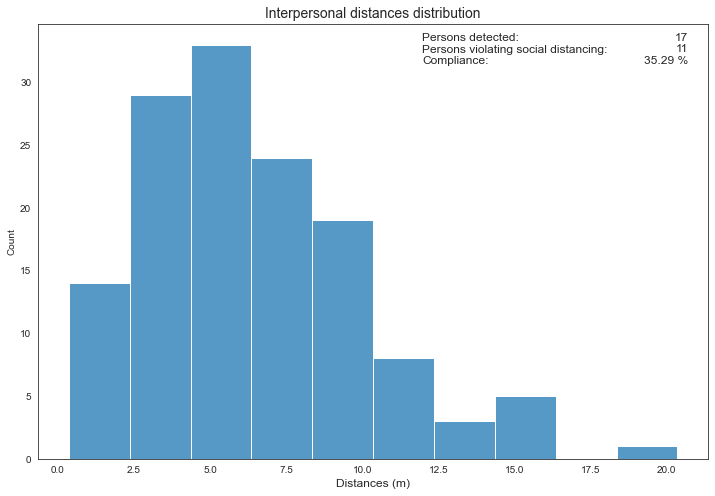

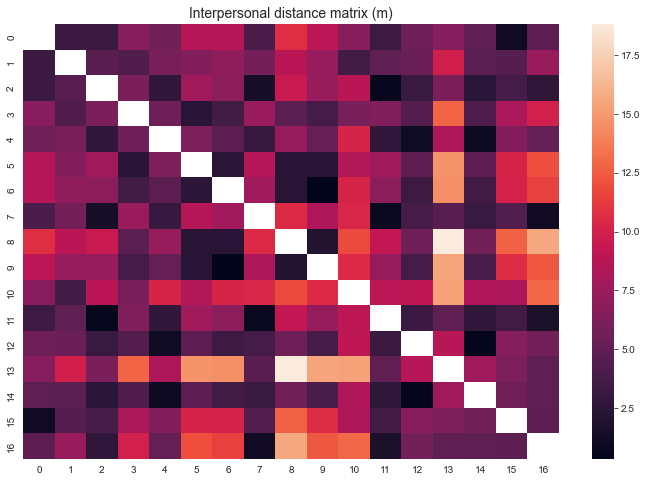


Time taken: 1.71 ms


In [316]:
social_distance = 2
method = 1

start = perf_counter()
distances, d_matrix, respect_social_distancing = distances_distribution(keypoints, social_distance, method)
t = perf_counter() - start

nb_non_compliant = d_matrix.shape[0]-sum(respect_social_distancing)

# Diplay distances histogram
plt.figure(figsize=(12, 8))
values = {'a': len(keypoints), 'b': nb_non_compliant, 'c': (len(keypoints)-nb_non_compliant)/len(keypoints)*100}

labels = """Persons detected:
Persons violating social distancing:
Compliance:"""

tmpl = """{a:1.0f}
{b:1.0f}
{c:1.2f} %"""

b = sns.histplot(data=distances, binwidth=2)
mystr = tmpl.format(**values)
plt.text(b.get_xlim()[1]*0.56, b.get_ylim()[1]*0.98, labels, va='top', fontsize=12)
plt.text(b.get_xlim()[1]*0.97, b.get_ylim()[1]*0.98, mystr, va='top', ha='right', fontsize=12)
plt.xlabel("Distances (m)", fontsize=12)
plt.title('Interpersonal distances distribution', fontsize=14)
plt.show()

# Diplay distance matrix
plt.figure(figsize=(12, 8))
ax = sns.heatmap(d_matrix, annot=False)
plt.title("Interpersonal distance matrix (m)", fontsize=14)
plt.show()

# print("Persons detected: " + str(len(keypoints)))
# print("Persons violating social distancing: " + str(nb_non_compliant))
# print("Proportion of compliance: " + str(round((len(keypoints)-nb_non_compliant)/len(keypoints)*100, 2)) + " %")

print(f"\nTime taken: {round(t*1000, 2)} ms")

#### 3.4. Pose features scale - Social distancing

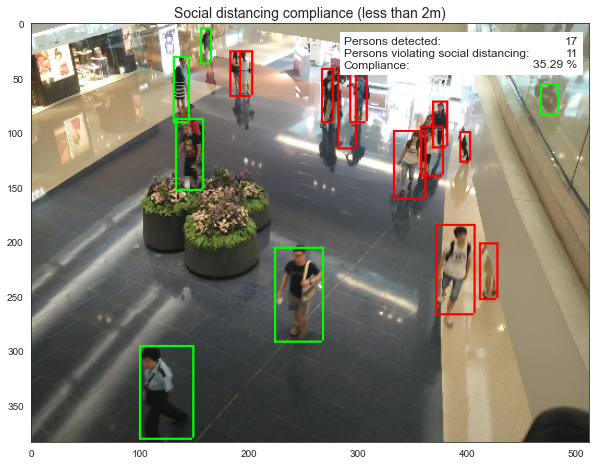

In [308]:
# Show the image with the reference
img_array = skimage.io.imread(os.path.join(IMAGE_DIR, image_files[img_index]))
plt.figure(figsize=(10,8))

# Get all bounding boxes for the example image and remove bad elements (for img_index = 35)
bboxes = alphap_results.loc[alphap_results['image_id'] == example_img]['box'].apply(np.array).iloc[[i for i in range(len(keypoints)) if i not in [17]]]

# Stack our seperate arrays into one large 2d array
bboxes = np.stack(bboxes, axis=0)

# Find number of boxes for given image
num_boxes = bboxes.shape[0]

# Convert bboxes to integers (if not already)
bboxes = bboxes.astype(int)

t = 2 # tickness

# Iterate through boxes
for i in range(num_boxes):
    # Get social distancing respect label
    if respect_social_distancing[i]:
        label = [0, 255, 0, 255]
    else:
        label = [255, 0, 0, 255]
    
    # Get coords for current box
    x_min, y_min, w, h = bboxes[i]

    # Find xmax & ymax for easier plotting
    x_max, y_max = x_min + w, y_min + h
    
    # Plot bbox on image with desired thickness
    img_array[y_min:y_min + t, x_min:x_max] = label
    img_array[y_max:y_max + t, x_min:x_max] = label
    img_array[y_min:y_max, x_min:x_min + t] = label
    img_array[y_min:y_max, x_max:x_max + t] = label

plt.imshow(img_array)
t = plt.text(plt.xlim()[1]*0.56, plt.ylim()[0]*0.03, labels, va='top', fontsize=12)
t.set_bbox(dict(facecolor='white'))
t = plt.text(plt.xlim()[1]*0.98, plt.ylim()[0]*0.03, mystr, va='top', ha='right', fontsize=12)
t.set_bbox(dict(facecolor='white'))
plt.title(f'Social distancing compliance (less than {social_distance}m)', fontsize=14)
plt.show()

#### 3.5. Pose features scale - Social clustering

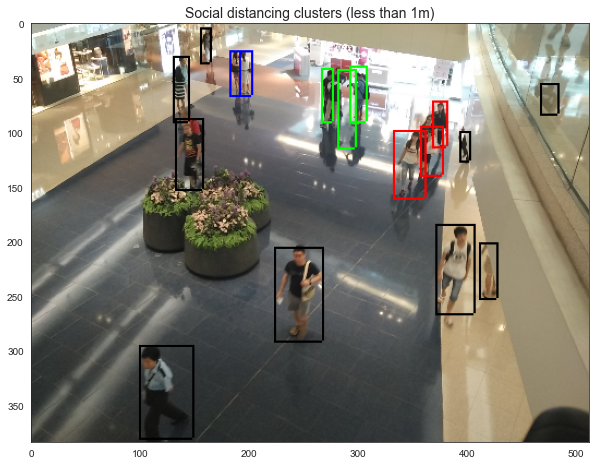

In [309]:
colors = [[255, 0, 0, 255], [0, 255, 0, 255], [0, 0, 255, 255],
          [255, 255, 0, 255], [255, 0, 255, 255], [0, 255, 255, 255],
          [255, 255, 255], [0, 0, 0, 255]]

mat = d_matrix.copy()
mat[np.isnan(mat)] = 0

# DBSCAN clustering analysis
dist_max = 1 # two persons close to less than this distance are whithin the same cluster
db = DBSCAN(eps=dist_max, min_samples=2, metric="precomputed").fit(mat)

# Show the image with the reference
img_array = skimage.io.imread(os.path.join(IMAGE_DIR, image_files[img_index]))
plt.figure(figsize=(10,8))

# Get all bounding boxes for the example image and remove bad elements (for img_index = 35)
bboxes = alphap_results.loc[alphap_results['image_id'] == example_img]['box'].apply(np.array).iloc[[i for i in range(len(keypoints)) if i not in [17]]]

# Stack our seperate arrays into one large 2d array
bboxes = np.stack(bboxes, axis=0)

# Find number of boxes for given image
num_boxes = bboxes.shape[0]

# Convert bboxes to integers (if not already)
bboxes = bboxes.astype(int)

t = 2 # tickness

# Iterate through boxes
for i in range(num_boxes):
    # Get social distancing respect label
    label = colors[db.labels_[i]]
    
    # Get coords for current box
    x_min, y_min, w, h = bboxes[i]

    # Find xmax & ymax for easier plotting
    x_max, y_max = x_min + w, y_min + h
    
    # Plot bbox on image with desired thickness
    img_array[y_min:y_min + t, x_min:x_max] = label
    img_array[y_max:y_max + t, x_min:x_max] = label
    img_array[y_min:y_max, x_min:x_min + t] = label
    img_array[y_min:y_max, x_max:x_max + t] = label

plt.imshow(img_array)
plt.title(f'Social distancing clusters (less than {dist_max}m)', fontsize=14)
plt.show()

### 4. Position of persons estimation

#### 4.1. 3D coordinates to 2D image coordinates

In [4]:
def to_image(X, Y, Z): # X, Y on ground and Z axis for height
    """ Gives the 2D image output coordinates of a point given its 3D euclidian coordinates
    (with origin of 3D coordinates system projected on the center of the 2D image)"""
    f = 2 # Only change the image scale (keep proportions)
    theta = np.pi / 4
    H = 10
    
    x = f*X*np.sin(theta) / (H + np.cos(theta)*np.sin(theta)*Y - np.sin(theta)*np.sin(theta)*Z)
    y = f*(np.sin(theta)*np.sin(theta)*Y + np.sin(theta)*np.cos(theta)*Z) / (H + np.cos(theta)*np.sin(theta)*Y - np.sin(theta)*np.sin(theta)*Z)

    return [x, y]

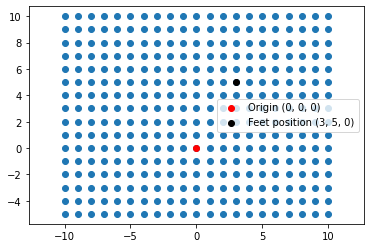

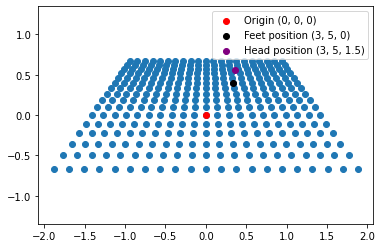

In [3]:
grid = np.array([[x, y] for x in range(-10, 10+1) for y in range(-5, 10+1)])

coord = (3, 5)
h = 1.5 # Average height size of a person

plt.figure()
plt.scatter(grid[:, 0], grid[:, 1])
plt.scatter(0, 0, c='red', label='Origin (0, 0, 0)')
plt.scatter(coord[0], coord[1], c='black', label = f'Feet position ({coord[0]}, {coord[1]}, 0)')
plt.axis('equal')
plt.legend()
plt.show()

# Grid on image (points projected on camera focal plan)
r = []
for e in grid:
    r.append(to_image(e[0], e[1], 0))
r = np.array(r)

# Diplay image
plt.figure()
plt.scatter(r[:, 0], r[:, 1])
plt.scatter(to_image(0, 0, 0)[0], to_image(0, 0, 0)[1], c='red', label='Origin (0, 0, 0)')
plt.scatter(to_image(coord[0], coord[1], 0)[0], to_image(coord[0], coord[1], 0)[1], c='black', label = f'Feet position ({coord[0]}, {coord[1]}, 0)')
plt.scatter(to_image(coord[0], coord[1], h)[0], to_image(coord[0], coord[1], h)[1], c='purple', label = f'Head position ({coord[0]}, {coord[1]}, {h})')
plt.axis('equal')
plt.legend()
plt.show()